In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import Transformer
import tqdm
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
device = torch.device("mps")

In [7]:
import importlib

importlib.reload(Transformer)

output_dim = 2  # To begin with we can use a Gaussian with mean and variance
d_model = 1
num_heads = 1
num_layers = 3
d_ff = 1024
max_seq_length = 100
dropout = 0.

transformer = Transformer.Decoder_Transformer(
    output_dim,
    d_model,
    num_heads,
    num_layers,
    d_ff,
    max_seq_length,
    dropout,
    device=device
).to(device)


# print(transformer(y_train[0:2])[:, :, 0])
# print(transformer(y_train[0].unsqueeze(0))[:, :, 1])
# print(transformer.generate_mask(y_train[0].unsqueeze(0)))
# prediction = transformer.generate(times[0].unsqueeze(0), 10)
# plt.plot(prediction.squeeze().detach().numpy())

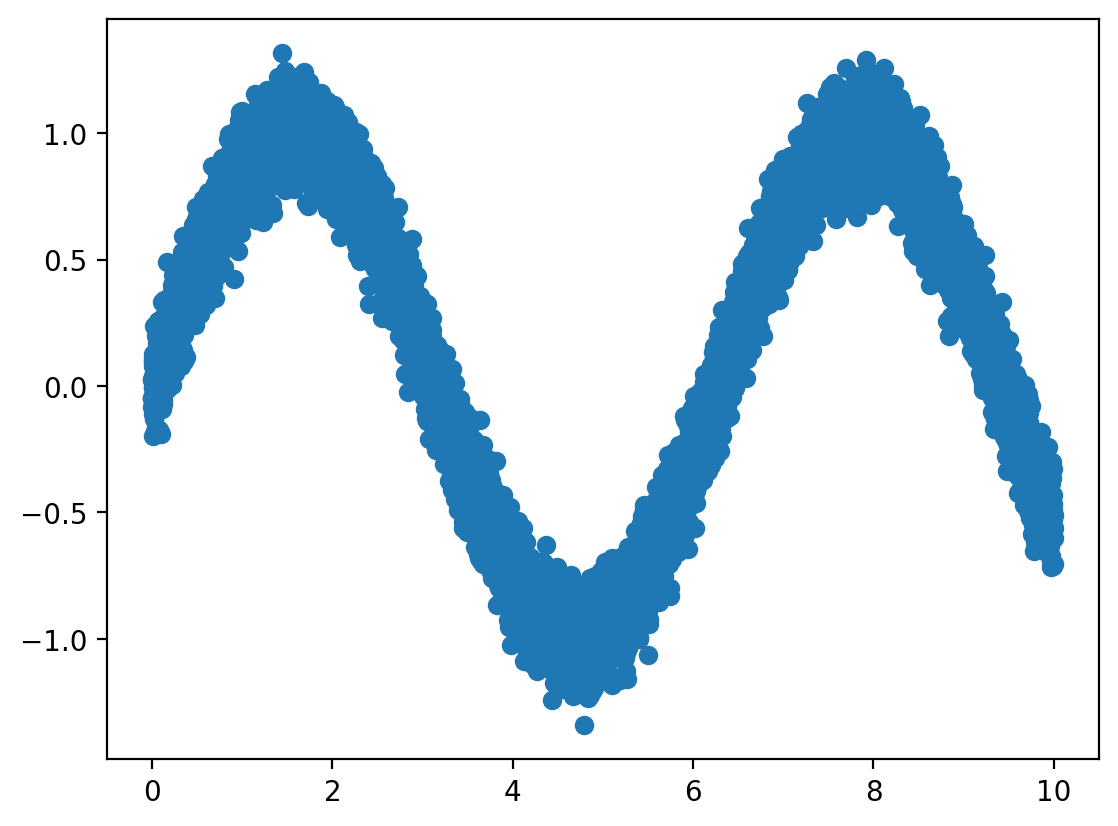

In [8]:
# Ok lets generate some fake time series data
n_data = 10_000
t = np.linspace(0, 10, n_data)
y1 = np.sin(t) + np.random.normal(0, 0.1, n_data)

# Lets plot it
plt.scatter(t, y1)
plt.show()

In [9]:
# We now need to package this up into random subsets of time series data
batch_size = 2048

def gen_sin_training_data(batch_size):
    # Generate random start points
    start_points = torch.randint(0, 10, (batch_size,)).to(device)
    batch_times = torch.stack(
        [
            torch.linspace(
                start_point.item(), start_point.item() + 10, 2 * max_seq_length + 1
            ).to(device)
            for start_point in start_points
        ]
    )
    y_vals = torch.stack(
        [
            torch.sin(batch_time).to(device) + torch.randn(2 * max_seq_length + 1).to(device) * 0.1
            for batch_time in batch_times
        ]
    )
    # The v values for the training should be the next data point
    return (
        batch_times[:, :2 * max_seq_length].unsqueeze(-1),
        y_vals[:, :2 * max_seq_length].unsqueeze(-1),
        y_vals[:, 1:],
    )


def gen_linear_training_data(batch_size):
    # Generate random start points
    start_points = torch.randint(0, 10, (batch_size,))
    batch_times = torch.stack(
        [
            torch.linspace(
                start_point.item(), start_point.item() + 10, 2 * max_seq_length + 1
            )
            for start_point in start_points
        ]
    )
    y_vals = torch.stack(
        [
            batch_time + torch.randn(2 * max_seq_length + 1) * 0.1
            for batch_time in batch_times
        ]
    )
    # The v values for the training should be the next data point
    return (
        batch_times[:, :2 * max_seq_length].unsqueeze(-1),
        y_vals[:, :2 * max_seq_length].unsqueeze(-1),
        y_vals[:, 1:],
    )


#times, y_train, y_true = gen_sin_training_data(batch_size)
# times, y_train, y_true = gen_linear_training_data(batch_size)
#for i in range(10):
#    plt.plot(times[i], y_train[i] + i)
#    plt.plot(times[i], y_true[i] + i)

#plt.show()

In [12]:
optimizer = optim.Adam(transformer.parameters(), lr=0.001)

def Gaussian_loss(transformer_pred, y_true, epsilon=torch.tensor(1e-6, dtype=torch.float32).to(device)):
    # Splitting the output into mean and variance
    mean = transformer_pred[:, :, 0]
    var = torch.nn.functional.softplus(transformer_pred[:, :, 1]) + epsilon

    # Calculating the Gaussian negative log-likelihood loss
    loss = torch.mean((y_true - mean) ** 2 / var + torch.log(var))
    # loss = torch.mean((y_true - mean) ** 2)

    return loss


transformer.train()

losses = []

for rnd in range(50):
    if rnd < 25:
        batch_size = 64
    else:
        batch_size = 128
    with tqdm.trange(100) as progress:
        for epoch in progress:
    
            times, y_train, y_true = gen_sin_training_data(batch_size)
            optimizer.zero_grad()
            output = transformer(y_train)
            loss = Gaussian_loss(output, y_true)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            
            progress.set_postfix(ordered_dict={'loss: ': loss.item()})
#    if epoch % 100 == 0:
#        sequence_length = 50

#        prediction = transformer.generate(y_train[0].unsqueeze(0), sequence_length)

#        plt.figure(figsize=(7, 5))
#        plt.plot(times[0], y_train[0])
#        T = torch.max(times[0]).numpy() - torch.min(times[0]).numpy()
#        plt.plot(
#            np.linspace(0, T, sequence_length) + torch.max(times[0]).numpy(),
#            prediction.squeeze().detach().numpy(),
#        )
#        plt.show()

#        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

#plt.loglog(losses)

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 92/100 [00:11<00:01,  7.97it/s, loss: =-2.8]


KeyboardInterrupt: 

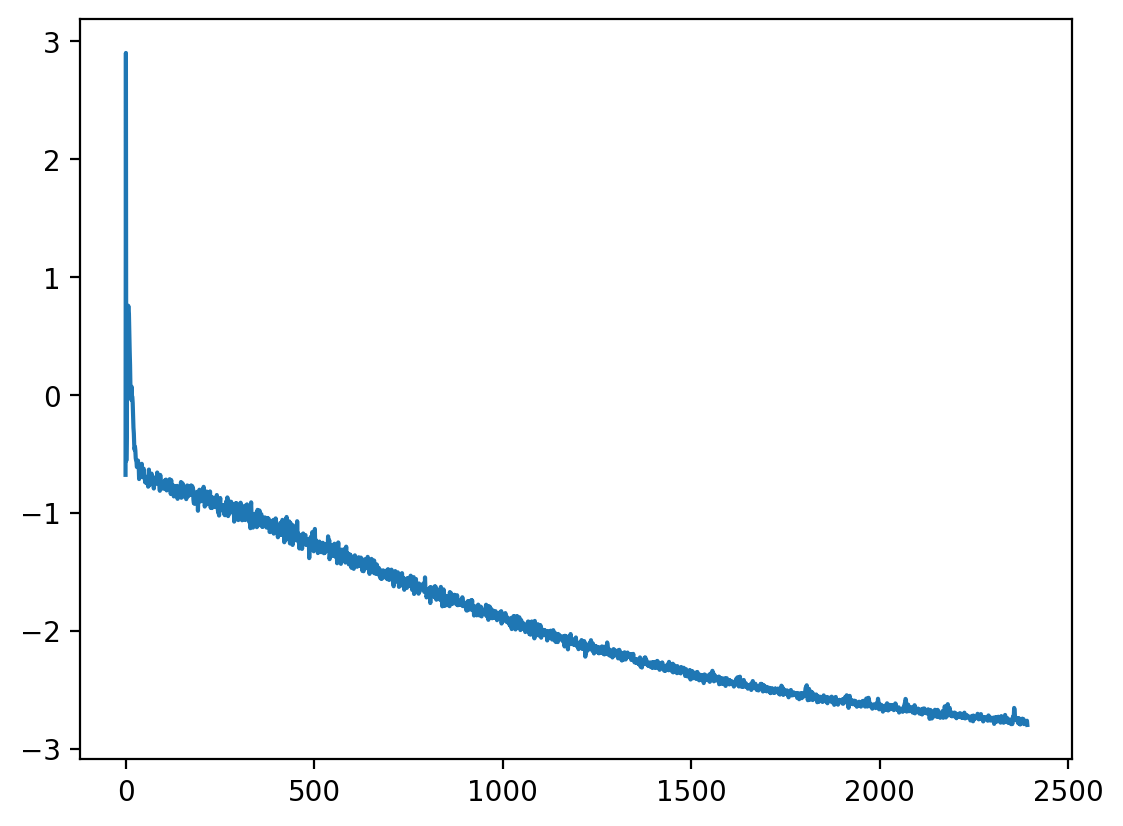

In [13]:
plt.plot(losses)

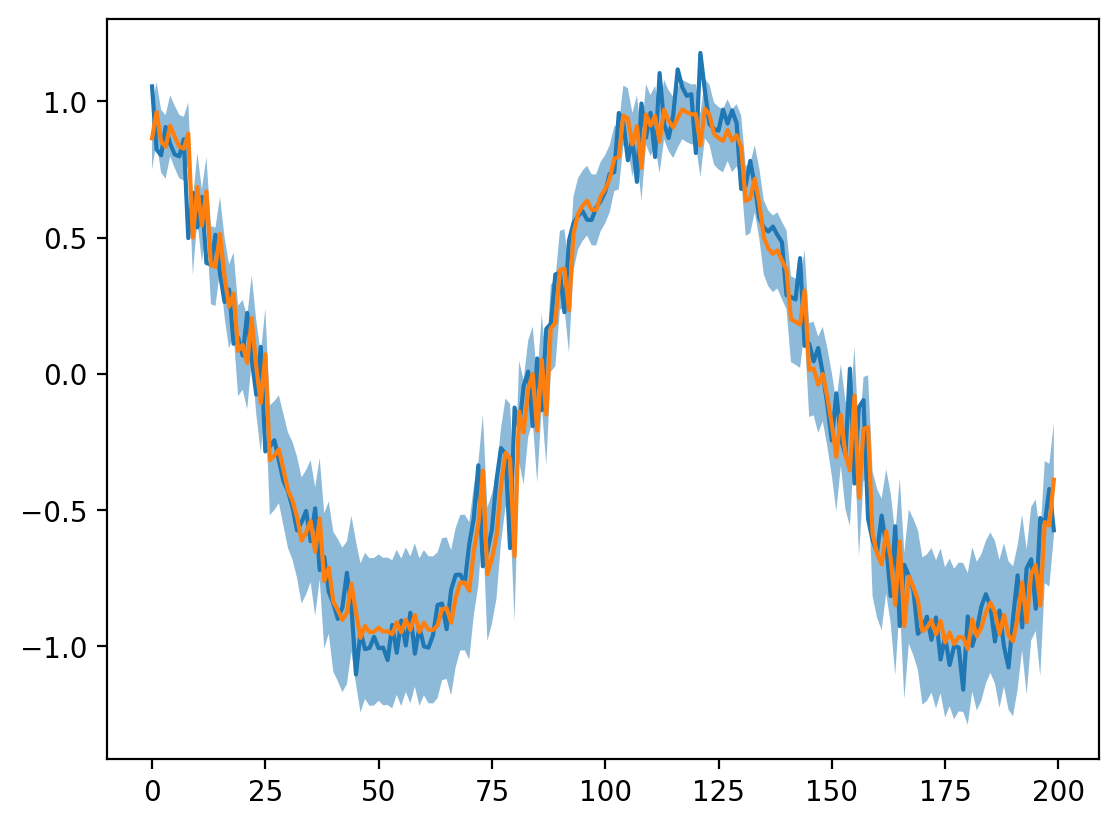

In [30]:
i = 0
output = transformer(y_train)
plt.plot(y_true[i,:].cpu())
mean = output[i,:,0].detach().cpu()
std = torch.sqrt(torch.nn.functional.softplus(output[i, :, 1].detach().cpu()))
plt.plot(mean)
plt.fill_between(np.arange(mean.shape[0]), mean - std, mean + std, alpha=0.5)
plt.show()

In [39]:
# Generate the next n_sequence elements
n_sequence = 100
generated_sequence = []

# Initial input for the model
current_input = y_train[0].unsqueeze(0)

for _ in range(n_sequence):
    # Pass the current input through the model
    output = transformer.forward(current_input)

    # Get the last output (most recent forecast)
    mean = output[:, -1, 0].unsqueeze(-1)
    std = torch.sqrt(torch.nn.functional.softplus(output[:, -1, 1]).unsqueeze(-1) + 1e-6)
    next_output = mean + torch.randn(mean.shape).to(device) * std

    # Append the predicted value to the generated sequence
    generated_sequence.append(next_output[:, 0])  # Assuming output_size is 1

    # Concatenate the new output to the current input for the next iteration
    current_input = torch.cat(
        [
            current_input,
            next_output.unsqueeze(0),
        ],
        dim=1,
    )[:,1:,:]

# Convert the list of tensors to a single tensor
sequence = torch.stack(
    generated_sequence, dim=1
)  # Shape: [batch_size, n_sequence]

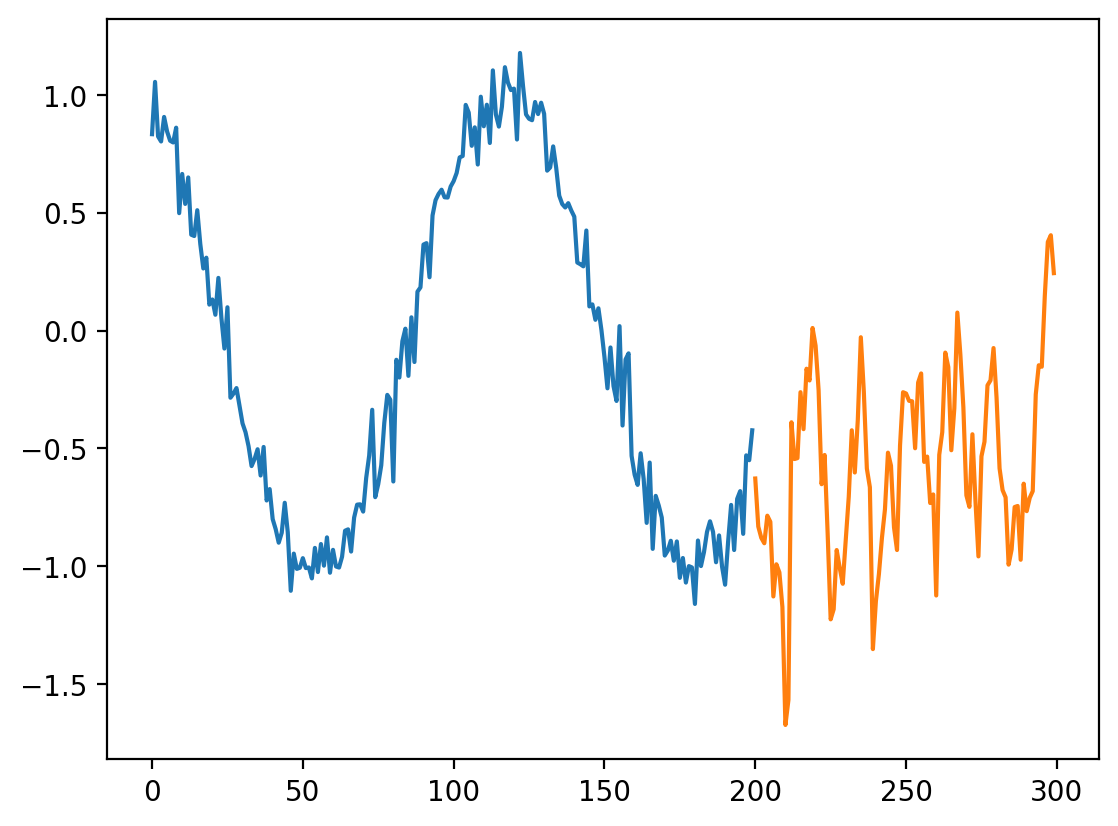

In [40]:
plt.plot(np.arange(0, y_train[0].shape[0]), y_train[0].cpu())
plt.plot(np.arange(y_train[0].shape[0], y_train[0].shape[0] + sequence.shape[1]), sequence[0,:].detach().cpu())
plt.show()

In [18]:
current_input.shape

torch.Size([1, 100])

In [19]:
y_train.shape

torch.Size([2048, 100, 1])